In [1]:
from pandas import concat
from pandas import read_csv


base_dir = "../data/analysis"
result = [
    read_csv(f"{base_dir}/{k}_form_generation_results.csv")
    for k in ["short", "long"]
]

In [2]:
def categorize_experiment(expr):
    if expr == "en_en" or expr == "en_en_en":
        return "Pure English"
    elif expr == "th_th" or expr == "th_th_th":
        return "Pure Thai"
    elif expr == "en":
        return "X"
    else:
        return "Mixed"
    

result = concat(result, ignore_index=True)
result["performance"] = result["accuracy_revised"].combine_first(result["rouge"])
result["expr_type"] = result["experiment"].apply(categorize_experiment)
result["task_type"] = result["task"].apply(
    lambda x: "short" if x in ["MMLU", "ThaiExam", "WTI - MC"] else "long"
)
result

,model,experiment,accuracy,uncertainty,accuracy_revised,answer_pred_revised,ifhr,temperature,task,model_type,rouge,wle,performance,expr_type,task_type
0,llama3,en_en,0.606801,0.350071,0.606801,0.350071,0.000064,1.0,MMLU,Base,NaN,NaN,0.606801,Pure English,short
1,qwen15,en_en,0.000000,1.540200,0.216137,1.391730,0.792408,1.0,MMLU,Base,NaN,NaN,0.216137,Pure English,short
2,qwen25,en_en,0.000000,1.385335,0.368081,1.225596,0.446745,1.0,MMLU,Base,NaN,NaN,0.368081,Pure English,short
3,otg,en_en,0.000000,0.561357,0.587644,0.548167,0.137096,1.0,MMLU,CPT,NaN,NaN,0.587644,Pure English,short
4,sailor,en_en,0.000057,1.175968,0.390678,0.999252,0.288178,1.0,MMLU,CPT,NaN,NaN,0.390678,Pure English,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,llama31,en_th_th,NaN,4.497624,NaN,NaN,0.050946,1.0,WTI - SUM,MLLM,0.310378,0.470976,0.310378,Mixed,long
196,llama31,th_en_en,NaN,4.819253,NaN,NaN,0.255979,1.0,WTI - SUM,MLLM,0.295461,0.368487,0.295461,Mixed,long
197,llama31,th_en_th,NaN,6.769542,NaN,NaN,0.182976,1.0,WTI - SUM,MLLM,0.143937,0.972354,0.143937,Mixed,long
198,llama31,th_th_en,NaN,7.583318,NaN,NaN,0.890066,1.0,WTI - SUM,MLLM,0.049054,0.390725,0.049054,Mixed,long


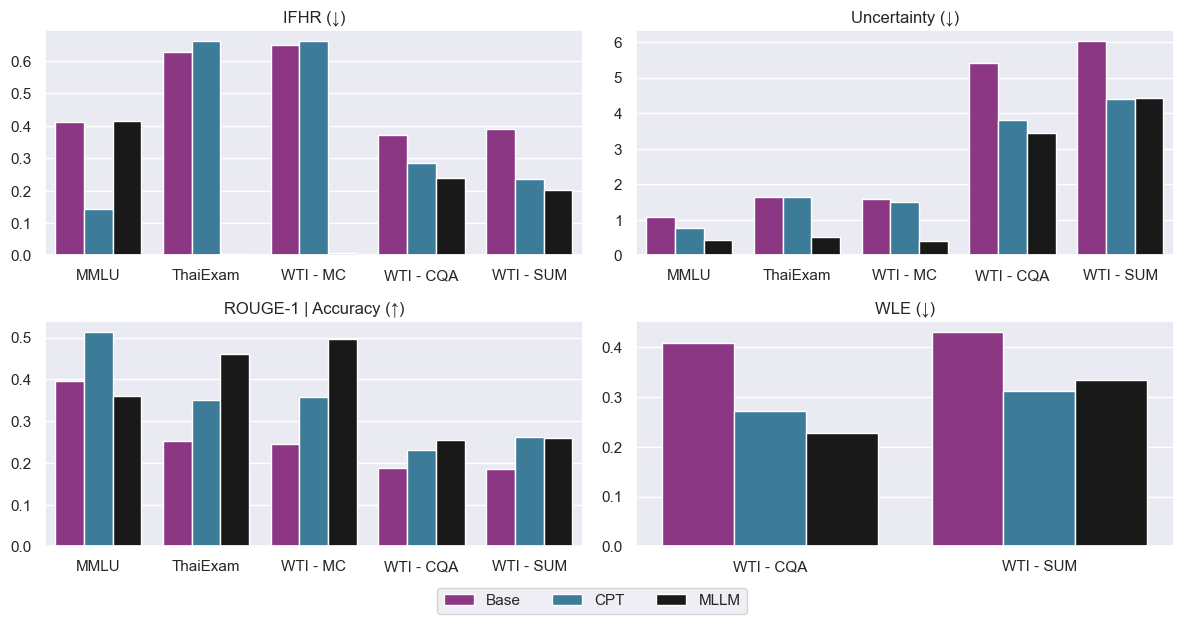

In [3]:
from src.utils.viz import plot_overall, plot_agg_expr


plot_overall(result)

In [3]:
result_agg = (
    result
    .groupby(
        by=["model_type", "expr_type", "task_type"],
        as_index=False,
    )
    .agg(
        performance=("performance", "mean"),
        uncertainty=("uncertainty", "mean"),
        ifhr=("ifhr", "mean"),
        wle=("wle", "mean"),
    )
)

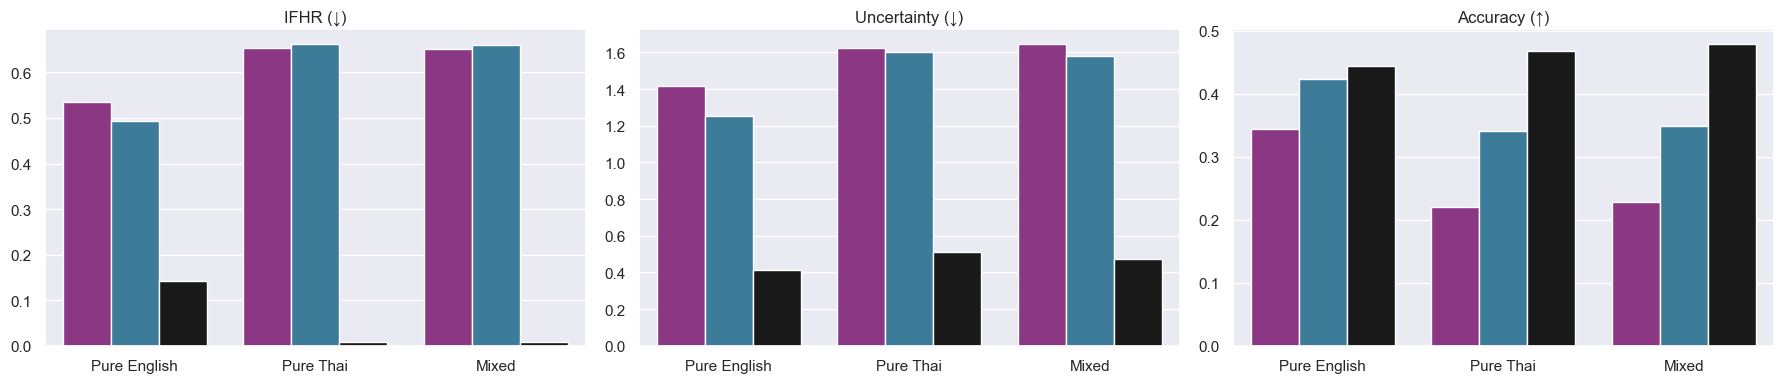

In [5]:
plot_agg_expr(result_agg, task_type="short")

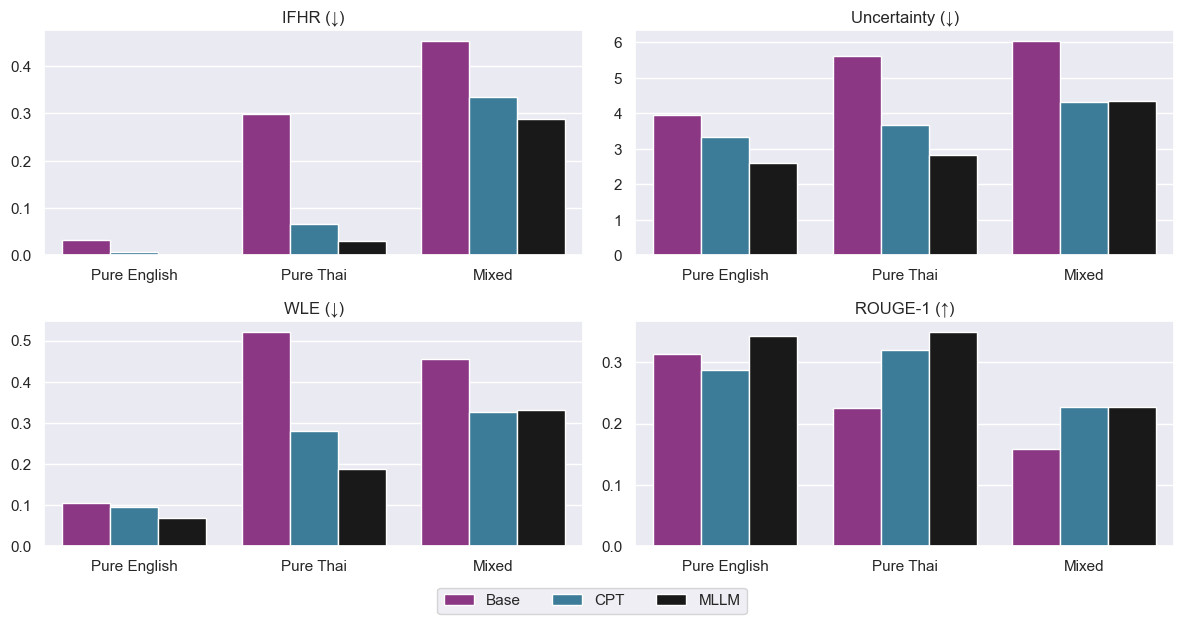

In [6]:
plot_agg_expr(result_agg, task_type="long", use_legend=True)

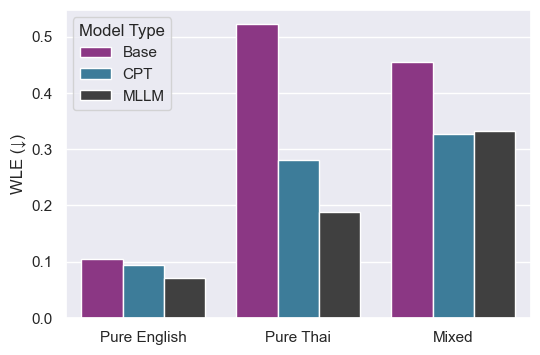

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.viz import handle_metric_name


metric = "WLE"
task_type = "long"
tmp_df = result_agg.query(f"task_type == '{task_type}'")
metric_to_show, metric_to_use = handle_metric_name(metric)

plt.figure(figsize=(6, 4))
sns.barplot(
    x="expr_type", 
    y=metric_to_use,
    data=tmp_df, 
    hue="model_type", 
    errorbar=None,
    palette=["#992990", "#2E82A8", "#404040"],
    order=["Pure English", "Pure Thai", "Mixed"],
)
plt.xlabel("")
# plt.ylabel("")
plt.ylabel(metric_to_show)
plt.legend(title="Model Type", loc="upper left")
plt.savefig("figure/expr_type_wle.png", dpi=500, bbox_inches="tight")
plt.show()